In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd
import datetime as dt

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect


In [6]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
# reflect the tables

base = automap_base()

base.prepare(engine, reflect=True)

In [8]:
# View all of the classes that automap found

base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table

measurement = base.classes.measurement
station = base.classes.station

In [10]:
# Create our session (link) from Python to the DB

session = Session(engine)

Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set
# Find column names

inspector = inspect(engine)

columns = inspector.get_columns('measurement')
for col in columns:
    print(col["name"], col["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23')

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 


precip = session.query(measurement.date, measurement.prcp).\
filter(measurement.date >= "2016-03-23").\
filter(measurement.date <= "2017-08-23").order_by(measurement.date.desc()).all()
precip[:5]

[('2017-08-23', 0.0),
 ('2017-08-23', 0.0),
 ('2017-08-23', 0.08),
 ('2017-08-23', 0.45),
 ('2017-08-22', 0.0)]

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column

precip_df = pd.DataFrame(data=precip, columns=['Date', 'Precipitation'])
precip_df

,Date,Precipitation
0,2017-08-23,0.00
1,2017-08-23,0.00
2,2017-08-23,0.08
3,2017-08-23,0.45
4,2017-08-22,0.00
...,...,...
3192,2016-03-23,0.72
3193,2016-03-23,NaN
3194,2016-03-23,1.05
3195,2016-03-23,0.31


In [15]:
# Sort the dataframe by date

precip_date = precip_df.sort_values('Date')

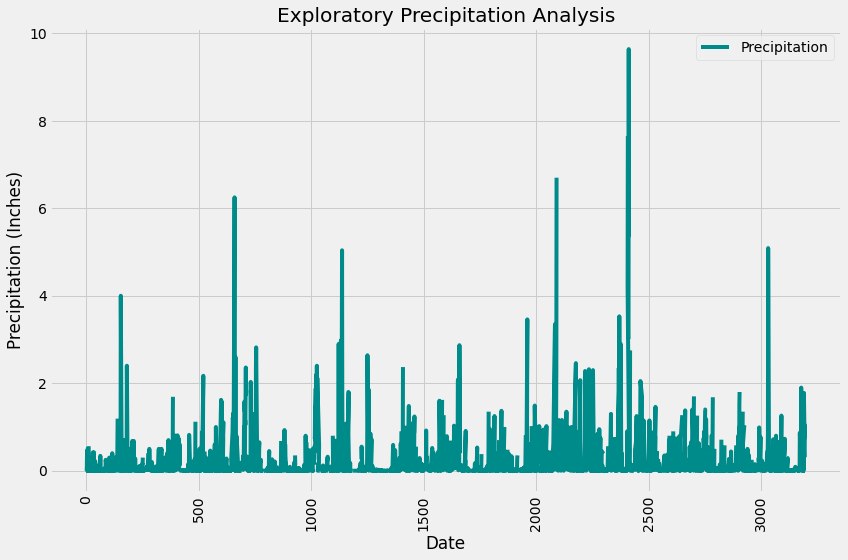

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data

precip_date.plot(figsize=(12,8), color='darkcyan')
plt.title("Exploratory Precipitation Analysis")
plt.xlabel("Date")
plt.ylabel("Precipitation (Inches)")
plt.xticks(rotation=90)
plt.tight_layout()

In [17]:
 # Use Pandas to calcualte the summary statistics for the precipitation data
    
precip_date.describe()

,Precipitation
count,2883.000000
mean,0.193059
std,0.518190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.150000
max,9.640000


Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number stations in the dataset

columns = inspector.get_columns('station')
for col in columns:
    print(col["name"], col["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [19]:
stations_total = session.query(station).filter(station.id).count()
stations_total

9

In [20]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

most_active = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()

most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [40]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.'USC00519281', 2772)

most_active_station = most_active[0][0]

lowest_temp = session.query(func.min(measurement.tobs)).\
filter(measurement.station == most_active_station).one()

highest_temp = session.query(func.max(measurement.tobs)).\
filter(measurement.station == most_active_station).one()

avg_temp = session.query(func.avg(measurement.tobs)).\
filter(measurement.station == most_active_station).one()

print(lowest_temp, highest_temp, avg_temp)

(54.0,) (85.0,) (71.66378066378067,)


In [42]:
last_year = session.query(measurement.date, measurement.tobs).filter(measurement.date >= "2016-03-23").\
filter(measurement.station == most_active_station).order_by(measurement.date).all()

In [43]:
station = pd.DataFrame(data=last_year).set_index('date')
station

,tobs
date,
2016-03-23,63.0
2016-03-24,64.0
2016-03-25,72.0
2016-03-26,76.0
2016-03-27,76.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


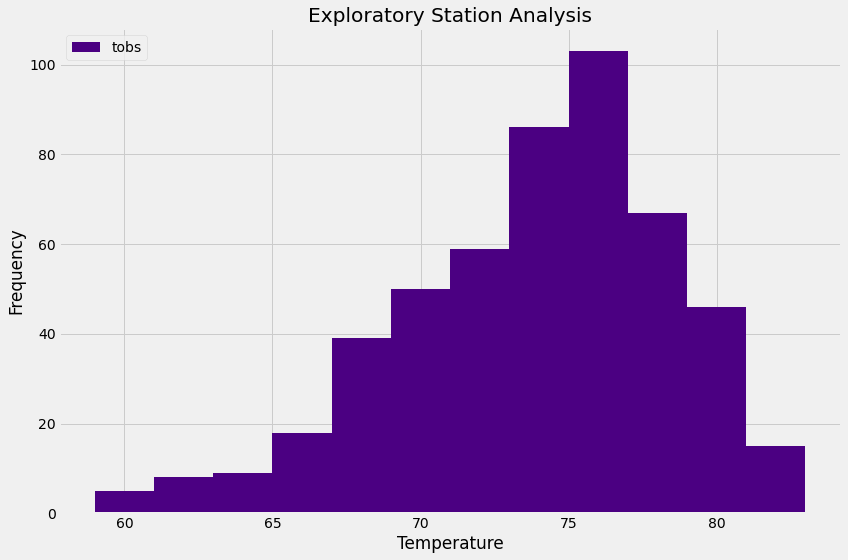

In [54]:
plt.figure(figsize=(12,8))
plt.hist(station['tobs'], bins = 12, color='indigo')
plt.title("Exploratory Station Analysis")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(["tobs"], loc="upper left")
plt.tight_layout()


In [55]:
session.close()